This is a continuation of the credit card fraud detection - data visualization post. I now build a machine learning model using Adaptive Synthetic Sampling to detect credit card frauds.

I came across Kaggle's dataset on [Credit Card Fraud Detection](https://www.kaggle.com/dalpozz/creditcardfraud) and decided to dive into this problem. This dataset includes transactions by European cardholders completed in September 2013. I want to explore some of the classification methods that could be used to solve this problem. The biggest challenge of this problem is the class imbalance - only 0.172% of all transactions in this dataset are fraudulent. The goal of this project is to start with a simple yet powerful model like [Logistic Regression](https://onlinecourses.science.psu.edu/stat504/node/149). Along with implementing logistic regression, I also wanted to explore some the methods used to handle class imbalance. In this post, I use [Adaptive Synthetic Sampling (ADASYN)](http://ieeexplore.ieee.org/document/4633969/?part=1), which is further discussed in this post.
<!--TEASER_END-->

# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Credit-Card-Fraud-Classification-using-Adaptive-Synthetic-Sampling-approach" data-toc-modified-id="Credit-Card-Fraud-Classification-using-Adaptive-Synthetic-Sampling-approach-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Credit Card Fraud Classification using Adaptive Synthetic Sampling approach</a></div><div class="lev2 toc-item"><a href="#Metrics-for-model-evaluation" data-toc-modified-id="Metrics-for-model-evaluation-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Metrics for model evaluation</a></div><div class="lev2 toc-item"><a href="#Adaptive-Synthetic-Sampling-(ADASYN)" data-toc-modified-id="Adaptive-Synthetic-Sampling-(ADASYN)-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Adaptive Synthetic Sampling (ADASYN)</a></div><div class="lev2 toc-item"><a href="#Model-selection-and-cross-validation-strategy" data-toc-modified-id="Model-selection-and-cross-validation-strategy-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Model selection and cross-validation strategy</a></div><div class="lev2 toc-item"><a href="#Define-functions" data-toc-modified-id="Define-functions-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Define functions</a></div><div class="lev1 toc-item"><a href="#Simple-Logistic-Regression" data-toc-modified-id="Simple-Logistic-Regression-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Simple Logistic Regression</a></div><div class="lev2 toc-item"><a href="#Understanding-Logistic-Regression" data-toc-modified-id="Understanding-Logistic-Regression-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Understanding Logistic Regression</a></div><div class="lev3 toc-item"><a href="#Training-logistic-regression" data-toc-modified-id="Training-logistic-regression-211"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Training logistic regression</a></div><div class="lev2 toc-item"><a href="#Train-Logistic-Regression-for-Credit-Card-Data" data-toc-modified-id="Train-Logistic-Regression-for-Credit-Card-Data-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Train Logistic Regression for Credit Card Data</a></div><div class="lev3 toc-item"><a href="#L2-Regularization-Parameter-Sweep" data-toc-modified-id="L2-Regularization-Parameter-Sweep-221"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>L2 Regularization Parameter Sweep</a></div><div class="lev3 toc-item"><a href="#L1-Regularization-Parameter-Sweep" data-toc-modified-id="L1-Regularization-Parameter-Sweep-222"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>L1 Regularization Parameter Sweep</a></div><div class="lev3 toc-item"><a href="#Learning-curve" data-toc-modified-id="Learning-curve-223"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Learning curve</a></div><div class="lev2 toc-item"><a href="#Final-Model---Logistic-Regression" data-toc-modified-id="Final-Model---Logistic-Regression-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Final Model - Logistic Regression</a></div><div class="lev1 toc-item"><a href="#References" data-toc-modified-id="References-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>References</a></div>

In [2]:
import os
os.chdir('D:/ML_Projects/CreditCardFraud/') #Set working directory
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import datetime
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, validation_curve, learning_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as mt
from itertools import cycle

from scipy import interp

from imblearn.over_sampling import ADASYN

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

sns.set_style('whitegrid')

%matplotlib inline

In [3]:
# Read credit card fraud data
cc_fraud = pd.read_csv('./Data/creditcard.csv')
print("Number of instances: %d" % cc_fraud.shape[0])
print("Number of features: %d" % cc_fraud.shape[1])
cc_fraud.head()

Number of instances: 284807
Number of features: 31


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
cc_fraud.Class.value_counts()*100/cc_fraud.shape[0]

0    99.827251
1     0.172749
Name: Class, dtype: float64

To deal with high class imbalance, we perform oversampling. The technique used to perform over sampling is discussed in the following section.

## Metrics for model evaluation

We have to keep imbalance in mind when evaluating model performance. An appropriate metric in this case would be an precision and recall, taking into account the class imbalance.

Precision, Recall and F1-score is defined as follows - 

Let,
* K = number of class
* TP = True Positives
* FP = False Positives
* TN = True Negative
* FN = False Negative

Then we can define precision and recall for each class *k* as,
$$ Precision = \frac {TP}{TP+FP} $$
Precision gives us the predictive value of the model, evaluating our model on the basis of how well our model can predict the positive class, in this case, a fraudulent transaction.

$$ Recall = \frac {TP}{TP+FN} $$
Recall is also equivalent to true-positive rate, evaluating our model performance on the basis of detecting the positive class, in this case, a fraudulent transaction.

Therefore we define the f1-score for class *k* which is just the harmonic mean of precision and recall for class *k* as,

$$ f1_k = 2*\frac {precision * recall}{precision + recall} $$

Then the weighted (weights are defined as the total number of instances for each class) average of f1-scores for all classes is given by 

$$ F1_{weighted} = \frac {\sum_{k=1}^{K} {w_k*f1_k}}{\sum_{k=1}^{K} w} $$

where $w_k$ is the total number of instances for class *k*

## Adaptive Synthetic Sampling (ADASYN)
Over-sampling using Adaptive Synthetic Sampling Approach. According to the [ADASYN paper](http://ieeexplore.ieee.org/document/4633969/?part=1), **ADASYN generates synthetic samples that are difficult to classify**, so that our machine learning model is able to learn more about the difficult samples. 

The idea of the algorithm is as follows - 
- Compute the class imbalance ratio 
- Calculate the total number of synthetic samples that need to be generated for the minority class. (G)
- For each of the minority sample, compute **K** nearest neighbours based on the Euclidean distance in the n-dimensional space and calculate the ratio $r_i$ as $$r_i = \frac{\Delta_i}{K}$$
where $\Delta_i$ is the number of samples in the **K** nearest neigbours that belong to the majority class.
- Normalize $r_i$ so that get a density distribution
- Calculate the number of synthetic samples that need to be generated for each of the minority samples
- For each of the minority samples, create synthetic samples in the following manner: $$s_i = x_i +(x_z - x_i)*\lambda$$
    - $x_z$: Randomly selected minority sample
    - $(x_z - x_i)$: Difference between the samples in the n-dimensional space
    - $\lambda$: Random number between $[0,1]$

Let's create synthetic samples using only the **PCA features.**

In [5]:
%%time
pd.options.mode.chained_assignment = None  # default='warn'
ros = ADASYN(n_neighbors = 5, ratio = 'auto', random_state=123, n_jobs = -1)

X = cc_fraud.drop(['Class', 'Time'], axis = 1)
y = cc_fraud['Class']

# X_data = np.array(X_data)
# y_data = np.array(y_data)

# Create train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 735215)

# Convert amount to standar scaler format
ss_obj = StandardScaler()
X_train['nAmount'] = ss_obj.fit_transform(X_train['Amount'].values.reshape(-1,1))
X_train = X_train.drop(['Amount'], axis=1)

# Fit standard scaler object to test data
X_test['nAmount'] = ss_obj.transform(X_test['Amount'].values.reshape(-1,1))
X_test = X_test.drop(['Amount'], axis=1)

X_ros, y_ros = ros.fit_sample(X_train, y_train)
print('Original data shape: {}'.format(Counter(y_train)))
print('Reshaped data shape: {}'.format(Counter(y_ros)))

Original data shape: Counter({0: 170604, 1: 280})
Reshaped data shape: Counter({1: 170618, 0: 170604})
Wall time: 2.36 s


## Model selection and cross-validation strategy

We will use train data to train our logistic regression model and a fraction of the training data as the validation data to select the regularization parameter for the model. After selecting our model based on the validation performance, we will check the performance on test data.

**Stratified k-fold cross validation** creates folds of train and test/validation data by maintaining the class distribution in each of the fold, thus each fold representing the class distribution of the population or the training data in this case.

In [6]:
# Define stratified k-fold cross validation object

K = 10 #Number of folds for cross validation
stratified_cv = StratifiedShuffleSplit(n_splits = K, random_state = 489567)

## Define functions

In [7]:
def plot_val_curve(train_scores, val_scores, param_range, plt_title):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(14,6))
    
    plt.title(plt_title)
    plt.xlabel("$C-Regularization parameter$")
    plt.ylabel("Accuracy")
    
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    
    plt.semilogx(param_range, val_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    
    plt.fill_between(param_range, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")

def plot_learning_curve(X,y,clf_estimator, cv_estimator, scorer, xlabel=''):
    train_x_axis, train_scores, test_scores =learning_curve(estimator=clf_estimator,
                                                           X=X,
                                                           y=y,
                                                           train_sizes=np.linspace(0.1, 1.0, 10),
                                                           cv=cv_estimator,
                                                           scoring=scorer,
                                                           exploit_incremental_learning=False,
                                                           n_jobs=-1)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_x_axis, train_mean,
             color='blue', marker='o',
             markersize=5, label='training accuracy')

    plt.fill_between(train_x_axis,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_x_axis, test_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label='validation accuracy')

    plt.fill_between(train_x_axis,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='green')

    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.tight_layout()
    

def plot_confusion_matrix(cm, class_names, title_text='Confusion Matrix', normalize=False):
    plt.figure(figsize=(10,5))
    acc = cm.diagonal().sum()/cm.sum()
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names,
               annot_kws={"size":15})
    plt.title(title_text+' Accuracy = {:.4f}'.format(acc), fontsize=20)
    plt.xlabel('Predicted', fontsize=16)
    plt.ylabel('Actual Class', fontsize=16)
    plt.tick_params(labelsize=14)

# Simple Logistic Regression

Logistic regression is a probabilistic model that models a binary response variable based on different explanatory variables. It has the following advantages - 

1. Easy model to implement and interpret. The weights help us explain the effect of individual explanatory variables on the response variable.

2. Although it is generally used for binary response variables, it can be extended to multiclass classification using 'one-vs-rest' methodology. In one-vs-all methodology, *K* binary classifiers are built for *K-class* classification. A given sample is assigned to the class for which it has been assigned the maximum probability.

3. Performs well on linearly seperable cases.

## Understanding Logistic Regression

To understand logistic regression, let's start with defining odds ratio.

$ Odds Ratio = \frac{p}{1-p} $

where p = the probability of the event of interest. e.g - probability of a patient surviving

Taking the log of the odds ratio, logit(p) is defined as

$logit(p) = log{\frac{p}{1-p}}$

which can be further expressed in linear form as

$ logit(p(y=1|x)) = w_0 + w_1x_1 + ... + w_mx_m = \sum_{i=1}^{m} {w_ix_i} = W^TX $

where, 
    * p(y=1|x) = conditional probability of a sample belonging to class 1
    * m = number of samples
    * X = explanatory features
    * W = weights

Using this information, we can now compute $p(y=1 | x)$. 

To compute, we need to compute the inverse of the logit function, which also known as logistic or the sigmoid function. It is defined as follows  

$ \phi(z) = \frac{1}{1+e^{-z}} $

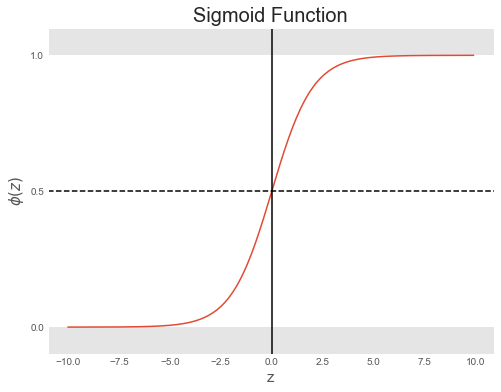

In [8]:
def sigmoid(z):
    return (1.0/(1.0+np.exp(-z)))
z = np.arange(-10,10,0.1)
phi_z = sigmoid(z)
plt.style.use('ggplot')
plt.figure(figsize=(8,6))
plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.axhspan(0.0,1.0,facecolor='1.0',alpha=1.0, ls='--')
plt.axhline(y=0.5,ls='--',color='k')
plt.yticks([0.0,0.5,1.0])
plt.ylim(-0.1,1.1)
plt.xlabel('z', fontsize=15)
plt.ylabel('$\phi(z)$', fontsize=15)
plt.title('Sigmoid Function', fontsize=20)
plt.grid('off')

From the above plot, we can see that $lim_{z\to\infty} {\phi(z)} = 1$ and $lim_{z\to-\infty} {\phi(z)} = 0$. Hence, the sigmoid function takes real numbers as input and transforms them into the range [0,1] with an intercept at $\phi(z) = 0.5$. This is convenient in terms of modeling probabilities. Hence, the predicted output can be written as,

$\hat{y} = 
\left\{
		\begin{array}{ll}
				1 & \mbox{if } \phi(z) \geq 0.5\\
				0 & \mbox otherwise
		\end{array}
\right.$

or

$\hat{y} = 
\left\{
		\begin{array}{ll}
				1 & \mbox{if } z\geq0\\
				0 & \mbox otherwise
		\end{array}
\right.$

Therefore, we have

$ P(Y=1|X) = \frac{1}{1+exp(-W^TX)} $

and

$ P(Y=0|X) = \frac{exp(W^TX)}{1+exp(W^TX)} $

From the above equation, the linear classification rule can be defined as 

$ ln\frac{P(Y=0|X}{P(Y=1|X} = w_0 + W^TX $


### Training logistic regression

Sum-squared error as the cost function for the model is defined as 

$ J(w) = \sum_{i} {\frac{1}{2} ({\phi (z^{i}) - y^{i}})^2} $

We need to maximize the likelihood of sample *x* belonging to class *k*. Therefore,

$ L(w) = P(y|x;w) = \prod_{i=1}^{N} P(y^{i}|x^{i},w) = \prod_{i=1}^{N} (\phi(z^{i})^{y^{i}}) (1-\phi(z^{i}))^{1-y^{i}}$

The conditional log-likelihood then can be defined as

$ l(w) = \sum_{i=1}^{N} [({y^{i}}\phi(z^{i})) + (1-y^{i})(1-\phi(z^{i}))]$

MLE for logistic regression is given by

$ w_{MLE} = \underset{w}{\operatorname{argmax}}  \sum_{i=1}^{N} [({y^{i}}\phi(z^{i})) + (1-y^{i})(1-\phi(z^{i}))]$

In words, we can say that, given a training set, we would like to find a set of parameters or weights such that $ P(y=1|x) $ is close to $1$ for a positive sample and is close to 0 otherwise.

The function can be looked from optimization point of view. 

## Train Logistic Regression for Credit Card Data

We are using only the **PCA features.**

### L2 Regularization Parameter Sweep

[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.3min finished


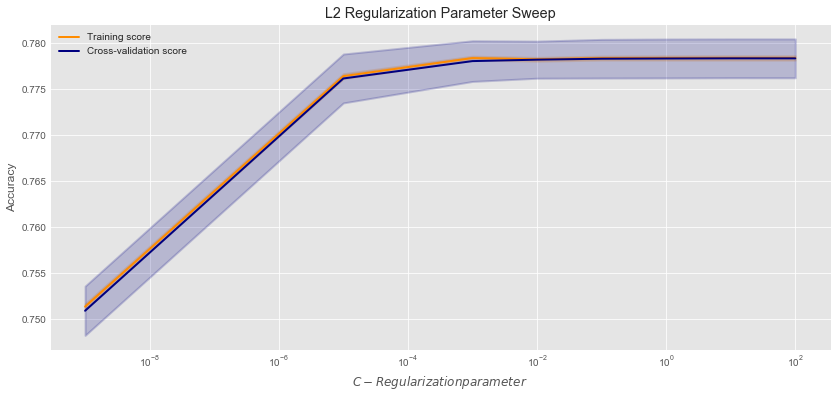

In [9]:
clf_LR_L2 = LogisticRegression(penalty='l2', solver='liblinear',
                            random_state=178926, n_jobs=-1, max_iter=1000)
param_C_range = [1e-9, 1e-5, 1e-3, 1e-2, 1e-1, 1.0,10,100]
train_scores, val_scores = validation_curve(estimator=clf_LR_L2, 
                                            X=X_ros, 
                                            y=y_ros, 
                                            param_name='C', 
                                            param_range=param_C_range,
                                            cv=stratified_cv,
                                            n_jobs=-1,
                                            verbose=1,
                                            scoring='accuracy')

# Average precision corresponds to the area under the precision recall curve

plot_val_curve(train_scores, val_scores, param_C_range, plt_title='L2 Regularization Parameter Sweep')
plt.xscale('log')
plt.show()

C = 0.01 can be used the regularization parameter value.

### L1 Regularization Parameter Sweep

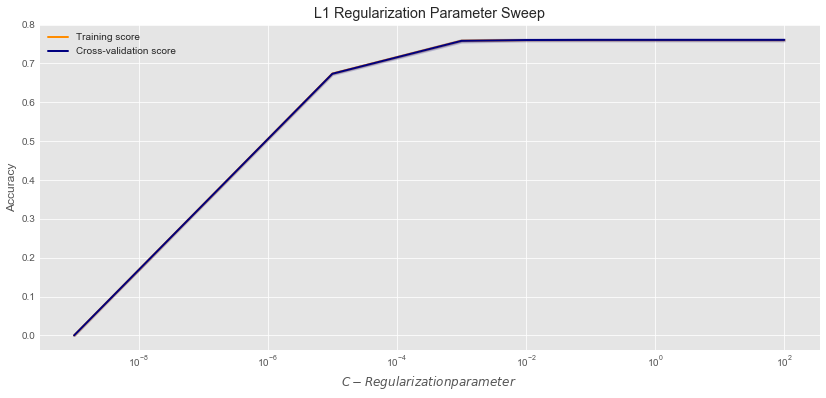

In [10]:
clf_LR_L1 = LogisticRegression(penalty='l1', solver='liblinear',
                            random_state=178926, n_jobs=-1, max_iter=1000)
param_C_range = [1e-9, 1e-5, 1e-3, 1e-2, 1e-1, 1.0,10,100]
train_scores, val_scores = validation_curve(estimator=clf_LR_L1, 
                                            X=X_ros, 
                                            y=y_ros, 
                                            param_name='C', 
                                            param_range=param_C_range,
                                            cv=stratified_cv,
                                            n_jobs=-1,
                                            scoring='f1')

plot_val_curve(train_scores, val_scores, param_C_range, plt_title='L1 Regularization Parameter Sweep')
plt.xscale('log')
plt.show()

### Learning curve

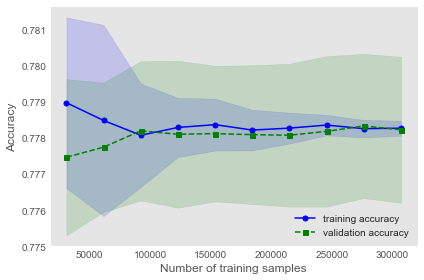

In [11]:
clf_LR = LogisticRegression(penalty='l2', C=0.01, solver='liblinear',
                            random_state=178926, n_jobs=-1, max_iter=1000)

plot_learning_curve(X_ros, y_ros, clf_LR, stratified_cv,'accuracy',xlabel='Number of training samples')

The model generalized well when cross-validated with sythetic samples present in the data set. The accuracy score converges for the training and the validation data sets as the number of samples increase in the training of the model.

d:\anaconda3\envs\ml_env\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


Cross-validation fold:  1
Cross-validation fold:  2
Cross-validation fold:  3
Cross-validation fold:  4
Cross-validation fold:  5
Cross-validation fold:  6
Cross-validation fold:  7
Cross-validation fold:  8
Cross-validation fold:  9
Cross-validation fold:  10

CV accuracy: 0.778 +/- 0.002

CV Recall: 0.704 +/- 0.004

CV F1_Score: 0.760 +/- 0.002

CV LogLoss: 7.660 +/- 0.070

CV AUPRC: 0.881 +/- 0.002


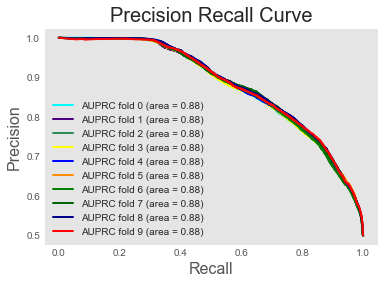

In [12]:
clf_LR_metrics = list()

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange',
                'green', 'darkgreen','darkblue', 'red', 'magenta'])
lw = 2

i = 0

for (train_idx, val_idx), color in zip(stratified_cv.split(X_ros, y_ros), colors):
    X_train, y_train = X_ros[train_idx], y_ros[train_idx]
    X_val, y_val = X_ros[val_idx], y_ros[val_idx]
    n_classes = np.unique(y_train) #Get total classes 
    
    #Define and fit a logistic regression classifier
    clf_LR = LogisticRegression(penalty='l2', C=0.01, solver='liblinear',
                               random_state=178926, n_jobs=-1, max_iter=1000)
    clf_LR.fit(X_train, y_train)
    
    #Predict class label and probability for the validation data set
    y_pred = clf_LR.predict(X_val)
    y_prob = clf_LR.predict_proba(X_val)
    
    #Compute classification metrics
    acc = mt.accuracy_score(y_val, y_pred)
    recall = mt.recall_score(y_val, y_pred)
    f1 = mt.f1_score(y_val, y_pred)
    logloss = mt.log_loss(y_val, y_pred)
    
    #Compute precision, recall and AUPRC for different levels of thresholds
    precisions, recalls, thresholds = mt.precision_recall_curve(y_val.ravel(), y_prob[:, 1].ravel(), pos_label=1)
    prc_auc = mt.average_precision_score(y_val, y_prob[:,1], average='weighted')
    plt.plot(recalls, precisions, lw=lw, color=color,
             label='AUPRC fold %d (area = %0.2f)' % (i, prc_auc))
    
    i +=1 #Counter for validation fold
    print("Cross-validation fold: ",i)
    
    clf_LR_metrics.append([acc, f1, recall, logloss, prc_auc])


#Summary of classification performance
clf_LR_metrics = pd.DataFrame(clf_LR_metrics, columns=['Accuracy','F1_Score', 'Recall', 'LogLoss','AUPRC'])

plt.legend(loc='best')
plt.grid()
plt.title('Precision Recall Curve', fontsize=20)
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)

print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(clf_LR_metrics.Accuracy), np.std(clf_LR_metrics.Accuracy)))
print('\nCV Recall: %.3f +/- %.3f' % (np.mean(clf_LR_metrics.Recall), np.std(clf_LR_metrics.Recall)))
print('\nCV F1_Score: %.3f +/- %.3f' % (np.mean(clf_LR_metrics.F1_Score), np.std(clf_LR_metrics.F1_Score)))
print('\nCV LogLoss: %.3f +/- %.3f' % (np.mean(clf_LR_metrics.LogLoss), np.std(clf_LR_metrics.LogLoss)))
print('\nCV AUPRC: %.3f +/- %.3f' % (np.mean(clf_LR_metrics.AUPRC), np.std(clf_LR_metrics.AUPRC)))

In [13]:
clf_LR_metrics

,Accuracy,F1_Score,Recall,LogLoss,AUPRC
0,0.775137,0.756745,0.699508,7.766552,0.878713
1,0.778038,0.760043,0.703024,7.666345,0.880371
2,0.777042,0.758798,0.701383,7.700760,0.880482
3,0.776104,0.758762,0.704196,7.733151,0.878395
4,0.777188,0.759361,0.703083,7.695699,0.880638
5,0.779826,0.762974,0.708709,7.604603,0.882200
6,0.776954,0.758174,0.699273,7.703795,0.879221
7,0.781438,0.763673,0.706248,7.548930,0.882277
8,0.781086,0.764710,0.711464,7.561079,0.884576
9,0.779445,0.761700,0.704958,7.617760,0.882295


## Final Model - Logistic Regression

d:\anaconda3\envs\ml_env\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


Test accuracy: 0.855

Test Precision: 0.012

Test Recall: 0.976

Test LogLoss: 5.023

Test AUPRC: 0.744


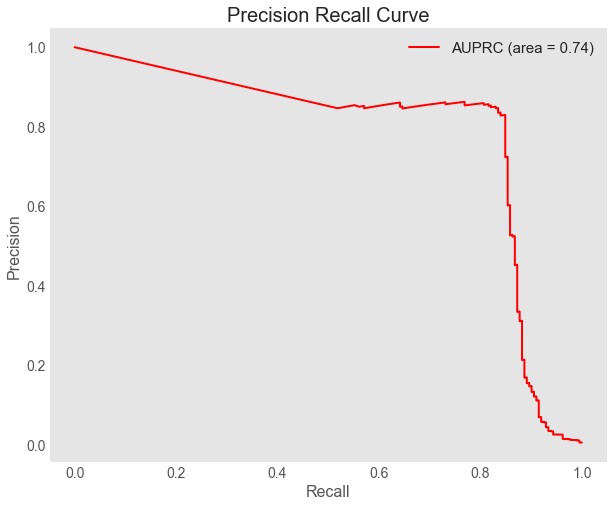

In [14]:
clf_LR = LogisticRegression(penalty='l2', C=0.01, solver='liblinear',
                            random_state=178926, n_jobs=-1, max_iter=1000)

clf_LR.fit(X_ros, y_ros)
    
#Predict class label and probability for the validation data set
y_pred = clf_LR.predict(X_test)
y_prob = clf_LR.predict_proba(X_test)

    
#Compute classification metrics
acc = mt.accuracy_score(y_test, y_pred)
precision = mt.precision_score(y_test, y_pred)
recall = mt.recall_score(y_test, y_pred)
# f1 = mt.f1_score(y_test, y_pred)
logloss = mt.log_loss(y_test, y_pred)
    
#Compute precision, recall and AUPRC for different levels of thresholds
precisions, recalls, thresholds = mt.precision_recall_curve(y_test.ravel(), y_prob[:, 1].ravel(), pos_label=1)
prc_auc = mt.average_precision_score(y_test, y_prob[:,1], average='weighted')

plt.figure(figsize=(10,8))
plt.plot(recalls, precisions, lw=lw, color=color,
         label='AUPRC (area = %0.2f)' % prc_auc)
plt.legend(loc='best', fontsize=15)
plt.grid()
plt.title('Precision Recall Curve', fontsize=20)
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.tick_params(labelsize=14)

print('Test accuracy: %.3f' % (acc))
print('\nTest Precision: %.3f' % (precision))
print('\nTest Recall: %.3f' % (recall))
print('\nTest LogLoss: %.3f' % (logloss))
print('\nTest AUPRC: %.3f' % (prc_auc))

Confusion matrix, without normalization


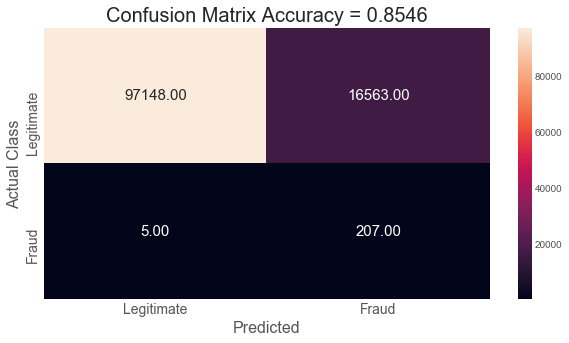

In [15]:
class_names = ['Legitimate', 'Fraud']
cm = mt.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, class_names)

In the context of the application, it is better to be safe than sorry. Hence, we do not worry about the false positive rate (9.7%) although we would like our model decrease the false positive rate.

# References

1. http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
2. http://ieeexplore.ieee.org/document/4633969/?part=1
3. http://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py
4. http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py